In [1]:
import pandas as pd
import itertools
import geopandas as gpd
import numpy as np
import os 
import json

from scipy.spatial.distance import cdist

from datetime import datetime, timedelta
from pprint import pp
#import torch
#import torch_geometric
from tqdm.notebook import tqdm

#from torch_geometric.data import HeteroData

import matplotlib.pyplot as plt

data_path='data'

In [2]:
target_pollutants='SO2 CO PM10 PM25 O3'.split()

### Read files

#### Air pollution data

Madrid

In [3]:
md_ap_df= pd.read_csv(os.path.join(data_path, '02_madrid_airpollution_clean.csv'), index_col=0, parse_dates=['date'])
md_ap_df= md_ap_df[md_ap_df['pollutant'].isin(target_pollutants)]
md_ap_df

H00   H01   H02   H03   H04   H05   H06   H07   H08   H09  ...    H17  \
0     1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...    1.0   
1     1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...    1.0   
2     1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...    1.0   
3     1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...    1.0   
4     1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...    1.0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
205  28.0  23.0  22.0  21.0  19.0  19.0  25.0  16.0  14.0  34.0  ...   27.0   
206  29.0  26.0  20.0  22.0  16.0  23.0  14.0  23.0  28.0  32.0  ...   30.0   
207  38.0  28.0  21.0  27.0  36.0  47.0  51.0  45.0  55.0  54.0  ...  106.0   
208  16.0  32.0  30.0  29.0  38.0  47.0  45.0  31.0  14.0   8.0  ...   96.0   
209   5.0  11.0  38.0  46.0  43.0  39.0  34.0  27.0  14.0  13.0  ...   98.0   

      H18   H19   H20   H21   H22   H23        id       date  pollutant  
0     1.0   1.0   1.0   1.0   1.0   1.0  28079004 2023-09-13        SO2  
1     1.0   1.0   1.0   1.0   1.0   1.0  28079004 2023-09-14        SO2  
2     1.0   1.0   1.0   1.0   1.0   1.0  28079004 2023-09-15        SO2  
3     1.0   1.0   1.0   1.0   1.0   1.0  28079004 2023-09-16        SO2  
4     1.0   1.0   1.0   1.0   1.0   1.0  28079004 2023-09-17        SO2  
..    ...   ...   ...   ...   ...   ...       ...        ...        ...  
205  22.0  25.0  30.0  37.0  56.0  41.0  28079047 2023-10-02       PM10  
206  19.0  23.0  28.0  36.0  44.0  48.0  28079047 2023-10-03       PM10  
207  87.0  77.0  74.0  40.0  19.0   8.0  28079049 2023-10-01         O3  
208  87.0  78.0  60.0  22.0   9.0   8.0  28079049 2023-10-02         O3  
209  89.0  88.0  82.0  61.0  54.0  26.0  28079049 2023-10-03         O3  

[210 rows x 27 columns]

In [4]:
md_pollutants_per_sensor_df= pd.read_csv(os.path.join(data_path, '02_madrid_pollutants_per_sensor.csv'), index_col=0)
md_pollutants_per_sensor_df

id           pollutants
0  28079004               SO2 CO
1  28079008  SO2 CO PM25 PM10 O3
2  28079047            PM25 PM10
3  28079049                   O3

Bilbao

In [5]:
bb_ap_df = pd.read_csv(os.path.join(data_path, '02_bilbao_airpollution_clean.csv'), index_col=0, parse_dates=['date'])
bb_ap_df= bb_ap_df[bb_ap_df['pollutant'].isin(target_pollutants)]
bb_ap_df

date pollutant    H00    H01    H02    H03    H04    H05    H06  \
0   2023-09-18        CO   0.20   0.20   0.22   0.22   0.22   0.23   0.23   
1   2023-09-18      PM10   8.00   4.00   3.00   3.00   4.00   5.00   6.00   
2   2023-09-18      PM25   3.00   2.00   1.00   1.00   1.00   2.00   2.00   
3   2023-09-18       SO2   9.00   7.00   8.00   7.00   7.00   7.00   7.00   
4   2023-09-19        CO   0.26   0.25   0.26   0.30   0.31   0.33   0.38   
..         ...       ...    ...    ...    ...    ...    ...    ...    ...   
139 2023-10-03        CO   0.30   0.27   0.30   0.33   0.33   0.36   0.42   
140 2023-10-03        O3  37.00  36.00  30.00  17.00  13.00  10.00  10.00   
141 2023-10-03      PM10  20.00  18.00  20.00  24.00  24.00  24.00  27.00   
142 2023-10-03      PM25  15.00  14.00  15.00  19.00  19.00  18.00  19.00   
143 2023-10-03       SO2   5.00   5.00   5.00   5.00   4.00   5.00   5.00   

       H07  ...    H15    H16    H17    H18    H19    H20    H21    H22  \
0     0.23  ...   0.21   0.20   0.23   0.24   0.27   0.27   0.27   0.25   
1     8.00  ...  11.00  11.00  12.00  12.00  12.00  11.00   9.00   8.00   
2     2.00  ...   5.00   5.00   6.00   6.00   6.00   5.00   4.00   4.00   
3     7.00  ...   7.00   7.00   6.00   7.00   7.00   7.00   7.00   7.00   
4     0.36  ...   0.26   0.23   0.23   0.26   0.30   0.32   0.32   0.31   
..     ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
139   0.45  ...   0.26   0.28   0.30   0.30   0.32   0.29   0.30   0.26   
140  11.00  ...  33.00  30.00  32.00  39.00  44.00  50.00  46.00  48.00   
141  32.00  ...  14.00   8.00   8.00   6.00   7.00  12.00  20.00  15.00   
142  20.00  ...   7.00   5.00   5.00   4.00   5.00   7.00   9.00   9.00   
143   5.00  ...   5.00   4.00   5.00   5.00   4.00   4.00   4.00   4.00   

       H23           id  
0     0.25    MAZARREDO  
1     7.00    MAZARREDO  
2     3.00    MAZARREDO  
3     7.00    MAZARREDO  
4     0.39    MAZARREDO  
..     ...          ...  
139   0.23  M_DIAZ_HARO  
140  57.00  M_DIAZ_HARO  
141  14.00  M_DIAZ_HARO  
142   6.00  M_DIAZ_HARO  
143   4.00  M_DIAZ_HARO  

[144 rows x 27 columns]

In [6]:
bb_pollutants_per_sensor_df= pd.read_csv(os.path.join(data_path, '02_bilbao_pollutants_per_sensor.csv'), index_col=0)
bb_pollutants_per_sensor_df

id           pollutants
0    MAZARREDO     CO PM10 PM25 SO2
1  M_DIAZ_HARO  CO O3 PM10 PM25 SO2

#### Traffic data

Madrid

In [7]:
md_traffic_files = [archivo for archivo in os.listdir(os.path.join(data_path, 'madrid_trafico')) if not archivo.startswith('.')]

traffic_df_lst=[]
for f in md_traffic_files:
    _df= pd.read_csv(os.path.join(data_path, 'madrid_trafico',f), parse_dates=['DateTime'])
    trf_id= f.split('_')[2]
    _df['id']=trf_id[1:] # We remove the first character as it is a 0
    traffic_df_lst.append(_df)

md_trf_df= pd.concat(traffic_df_lst, axis=0)
md_trf_df.head()

DateTime  Car  Motorcycle  Bus  Truck    id
0 2023-09-13 10:00:00  170           1   20     46  1302
1 2023-09-13 11:00:00  124           0   14     36  1302
2 2023-09-13 12:00:00  178           1   28     37  1302
3 2023-09-13 13:00:00  158           4   26     21  1302
4 2023-09-13 14:00:00  160          20   40     23  1302

Bilbao

In [8]:
target_trf_bilbao='37 42 8 41 4 30 68 69 52 44 5  32 33 34 35 65 72'.split()
bb_traffic_files = [archivo for archivo in os.listdir(os.path.join(data_path, 'bilbao_trafico')) if not archivo.startswith('.')]

bb_traffic_df_lst=[]
for f in bb_traffic_files:
    _df= pd.read_csv(os.path.join(data_path, 'bilbao_trafico',f), parse_dates=['DateTime'])
    sensor_num= f.split('_')[2]
    if sensor_num in target_trf_bilbao:
        _df['id']=str(sensor_num)
        bb_traffic_df_lst.append(_df)
        
bb_trf_df= pd.concat(bb_traffic_df_lst, axis=0)
bb_trf_df.head()        

DateTime  Car  Motorcycle  Bus  Truck  id
0 2023-09-18 08:00:00   10           0    0      1  30
1 2023-09-18 09:00:00   32           0    3      3  30
2 2023-09-18 10:00:00   40           0    3      3  30
3 2023-09-18 11:00:00   22           0    2      2  30
4 2023-09-18 12:00:00    0           0    0      0  30

#### Sensors' location

In [9]:
sensors_loc_gdf= gpd.read_file(os.path.join(data_path,'01_sensors_location.geojson'), driver='GeoJSON')  
sensors_loc_gdf['id']= sensors_loc_gdf['id'].replace('Mª DIAZ HARO','M_DIAZ_HARO') 
sensors_loc_gdf.head()

id        lat       lon    type                   geometry
0  1305  40.407658 -3.693109  camera  POINT (-3.69311 40.40766)
1  1304  40.409189 -3.692159  camera  POINT (-3.69216 40.40919)
2  1302  40.418975 -3.693114  camera  POINT (-3.69311 40.41898)
3  1317  40.418890 -3.696665  camera  POINT (-3.69667 40.41889)
4  1318  40.416659 -3.700281  camera  POINT (-3.70028 40.41666)

In [10]:
sensors_loc_gdf.tail()

id        lat       lon          type                   geometry
83     28079059  40.460726 -3.616341  airpollution  POINT (-3.61634 40.46073)
84     28079060  40.500548 -3.689731  airpollution  POINT (-3.68973 40.50055)
85    MAZARREDO  43.267506 -2.935188  airpollution  POINT (-2.93519 43.26751)
86  M_DIAZ_HARO  43.258803 -2.945657  airpollution  POINT (-2.94566 43.25880)
87       EUROPA  43.254911 -2.902376  airpollution  POINT (-2.90238 43.25491)

In [11]:
def haversine(coord1, coord2):
    """
    Calcular la distancia Haversine entre dos coordenadas geográficas en grados decimales.
    """
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    R = 6371  # Radio de la Tierra en kilómetros

    # Convertir grados decimales a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calcular diferencias de longitud y latitud
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calcular la distancia Haversine
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distancia = R * c
    return distancia

def generar_matriz_distancias_haversine(geodataframe, columna_id):
    # Extraer las coordenadas de los puntos en el GeoDataFrame
    puntos = geodataframe.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
    # Calcular la matriz de distancias usando la distancia Haversine
    matriz_distancias = cdist(puntos, puntos, haversine)
    
    # Asignar los IDs como índices y columnas en el DataFrame de la matriz de distancias
    matriz_distancias_df = pd.DataFrame(matriz_distancias, index=geodataframe[columna_id], columns=geodataframe[columna_id])
    
    return matriz_distancias_df

matriz_distancias_haversine = generar_matriz_distancias_haversine(sensors_loc_gdf, 'id')
print(matriz_distancias_haversine)

id                 1305        1304        1302        1317        1318  \
id                                                                        
1305           0.000000    0.188304    1.258458    1.284755    1.170662   
1304           0.188304    0.000000    1.091215    1.144221    1.078349   
1302           1.258458    1.091215    0.000000    0.300815    0.659193   
1317           1.284755    1.144221    0.300815    0.000000    0.394034   
1318           1.170662    1.078349    0.659193    0.394034    0.000000   
...                 ...         ...         ...         ...         ...   
28079059       8.777028    8.603270    7.985351    8.237116    8.629932   
28079060      10.332829   10.160709    9.074931    9.098829    9.370616   
MAZARREDO    324.135882  323.953482  322.900362  322.966959  323.269057   
M_DIAZ_HARO  323.020143  322.837836  321.784151  321.850167  322.151763   
EUROPA       323.302778  323.119968  322.069445  322.138666  322.443016   

id                 4308 

In [12]:
def generar_lista_de_fechas(inicio, fin):
    lista_fechas = []
    fecha_actual = inicio
    while fecha_actual <= fin:
        lista_fechas.append(fecha_actual)
        fecha_actual += timedelta(days=1)
    return lista_fechas

### Study of missing values (Nan)

Bilbao

In [13]:
vehicle_types= 'Car Motorcycle Bus Truck'.split()

for vt in vehicle_types:
    v_df= bb_trf_df[['DateTime', 'id', vt]]
    v_df= v_df.pivot_table(index='DateTime', columns='id', values=vt)
    print(vt, v_df.isna().sum())

Car id
30    0
32    0
33    0
34    0
35    0
37    0
4     0
41    0
42    0
44    0
5     0
52    0
65    0
68    0
69    0
72    0
8     0
dtype: int64
Motorcycle id
30    0
32    0
33    0
34    0
35    0
37    0
4     0
41    0
42    0
44    0
5     0
52    0
65    0
68    0
69    0
72    0
8     0
dtype: int64
Bus id
30    0
32    0
33    0
34    0
35    0
37    0
4     0
41    0
42    0
44    0
5     0
52    0
65    0
68    0
69    0
72    0
8     0
dtype: int64
Truck id
30    0
32    0
33    0
34    0
35    0
37    0
4     0
41    0
42    0
44    0
5     0
52    0
65    0
68    0
69    0
72    0
8     0
dtype: int64


Madrid

In [14]:
for vt in vehicle_types:
    v_df= md_trf_df[['DateTime', 'id', vt]]
    v_df= v_df.pivot_table(index='DateTime', columns='id', values=vt)
    print(vt, v_df.isna().sum())

Car id
1302    0
1303    0
1304    0
1305    0
1316    0
1317    0
1318    0
1323    0
1324    0
1331    0
1332    0
4308    0
4322    0
dtype: int64
Motorcycle id
1302    0
1303    0
1304    0
1305    0
1316    0
1317    0
1318    0
1323    0
1324    0
1331    0
1332    0
4308    0
4322    0
dtype: int64
Bus id
1302    0
1303    0
1304    0
1305    0
1316    0
1317    0
1318    0
1323    0
1324    0
1331    0
1332    0
4308    0
4322    0
dtype: int64
Truck id
1302    0
1303    0
1304    0
1305    0
1316    0
1317    0
1318    0
1323    0
1324    0
1331    0
1332    0
4308    0
4322    0
dtype: int64


### Plot data

#### Traffic data

In [15]:
def plot_traffic_data(trf_df):
    for vt in vehicle_types:
        v_df= md_trf_df[['DateTime', 'id', vt]]
        v_df= v_df.pivot_table(index='DateTime', columns='id', values=vt)
        v_df['max']= v_df.apply(lambda r: r.max(), axis=1)
        v_df['min']= v_df.apply(lambda r: r.min(), axis=1)
        v_df['mean']= v_df.apply(lambda r: r.mean(), axis=1)
        v_df['mean max min'.split()].plot(figsize=(15,5),grid=True, title=vt);

Bilbao

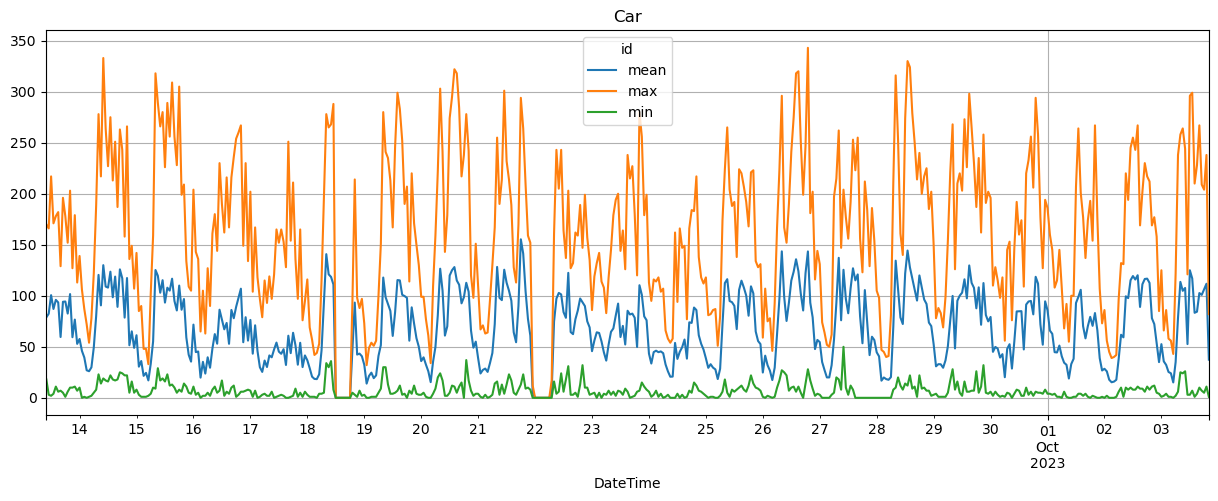

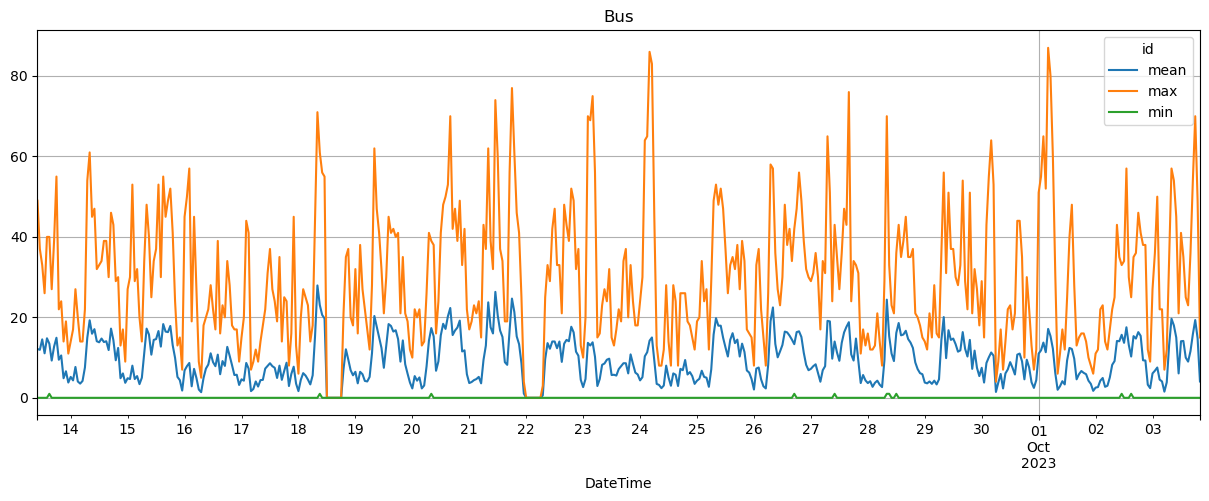

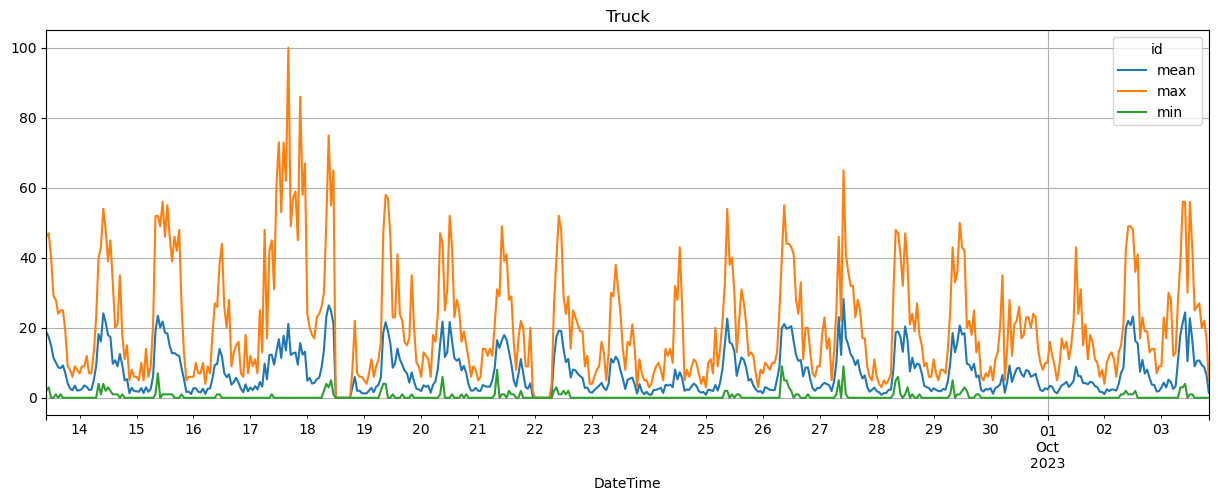

In [16]:
plot_traffic_data(bb_trf_df)

Madrid

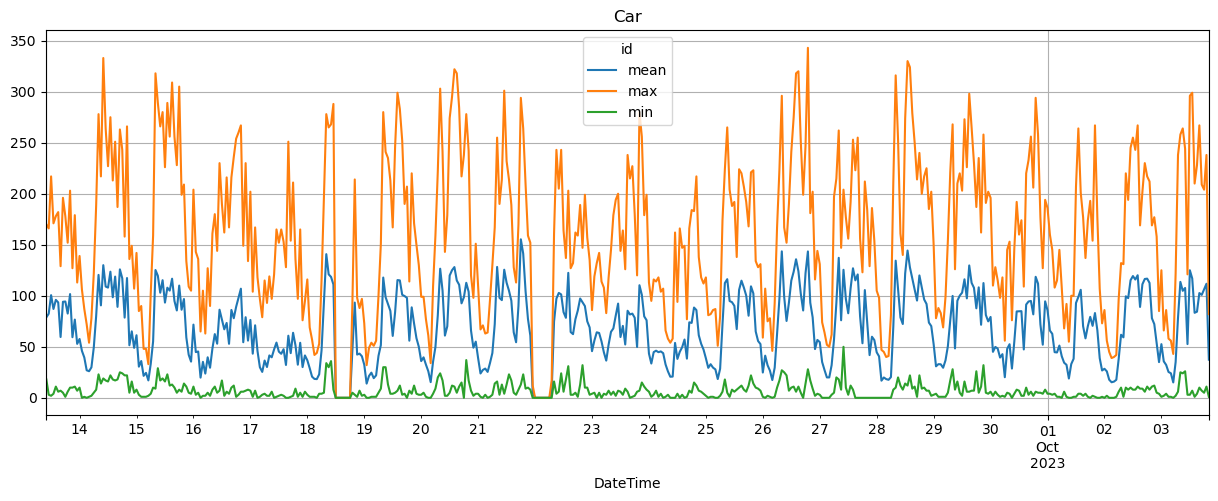

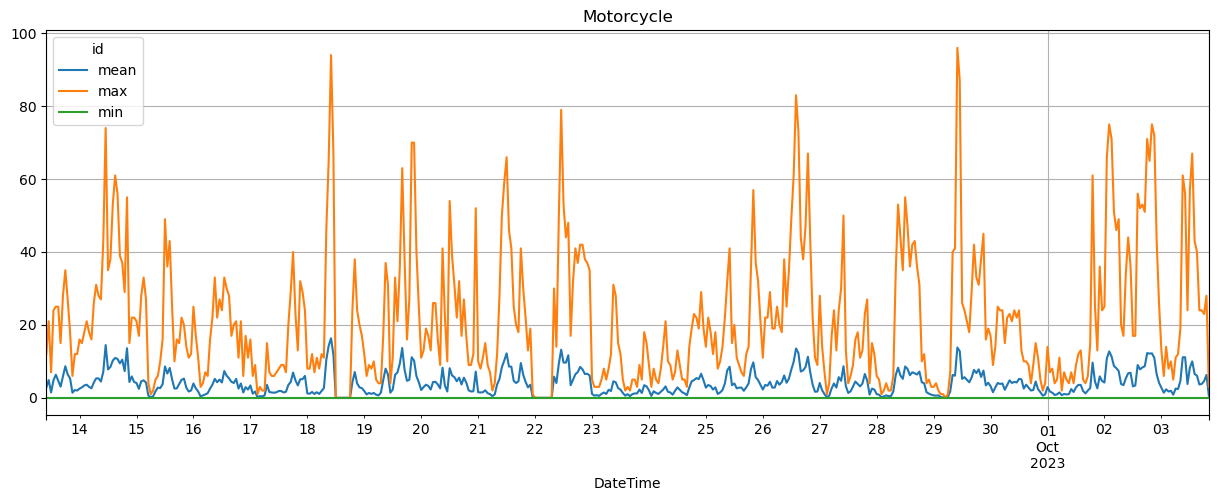

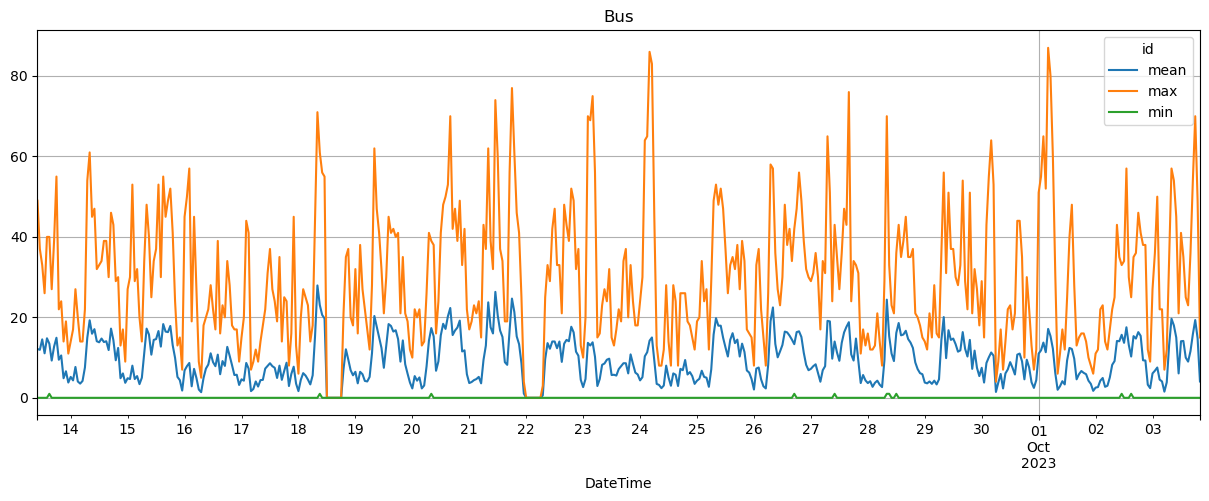

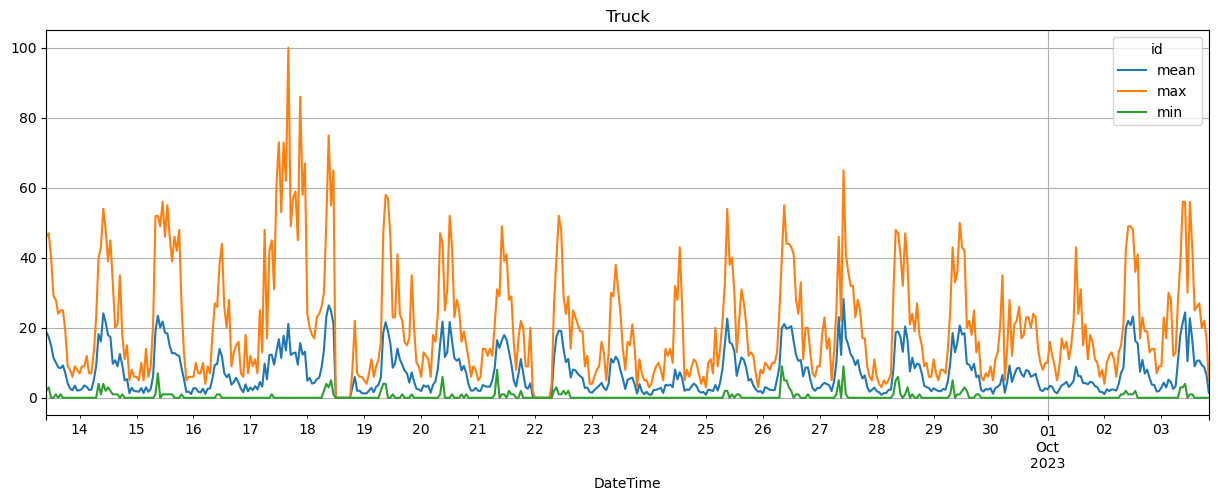

In [17]:
plot_traffic_data(md_trf_df)

#### Pollution data

In [18]:
def plot_ap(ap_df):
    melted_df = pd.melt(ap_df, id_vars=['id', 'date', 'pollutant'], 
                        value_vars=[f'H{i:02d}' for i in range(0, 24)],
                        var_name='Hora_old', value_name='Valor')
    melted_df['hour']= melted_df['Hora_old'].apply(lambda h: int(h[1:]))
    melted_df['date_str']= melted_df['date'].apply(lambda d: d.strftime('%Y-%m-%d'))
    melted_df['datetime_str']= melted_df.apply(lambda r: r['date_str']+' '+ str(r['hour'])+':00:00',axis=1)
    melted_df['datetime']= pd.to_datetime(melted_df['datetime_str'])
    melted_df= melted_df.drop(columns='date Hora_old hour date_str datetime_str'.split())
    
    for p in ap_df['pollutant'].unique():
        pollutant_df= melted_df[melted_df['pollutant']==p]
        pollutant_df= pollutant_df.pivot_table(index='datetime', columns='id', values='Valor')
        pollutant_df['max']= pollutant_df.apply(lambda r: r.max(), axis=1)
        pollutant_df['min']= pollutant_df.apply(lambda r: r.min(), axis=1)
        pollutant_df['mean']= pollutant_df.apply(lambda r: r.mean(), axis=1)
        pollutant_df['mean max min'.split()].plot(figsize=(15,5),grid=True, title=p, logy=True);

Bilbao

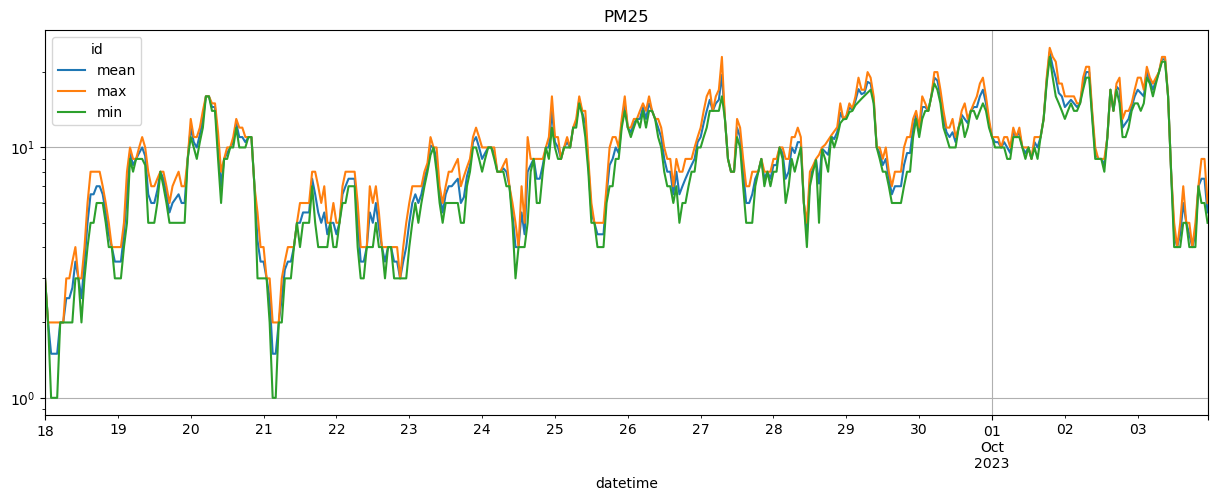

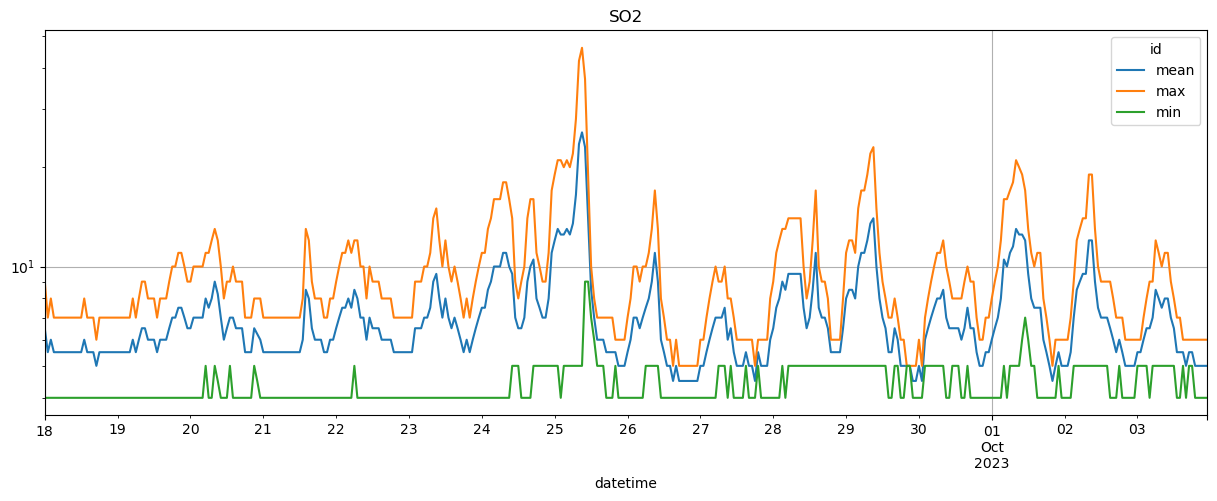

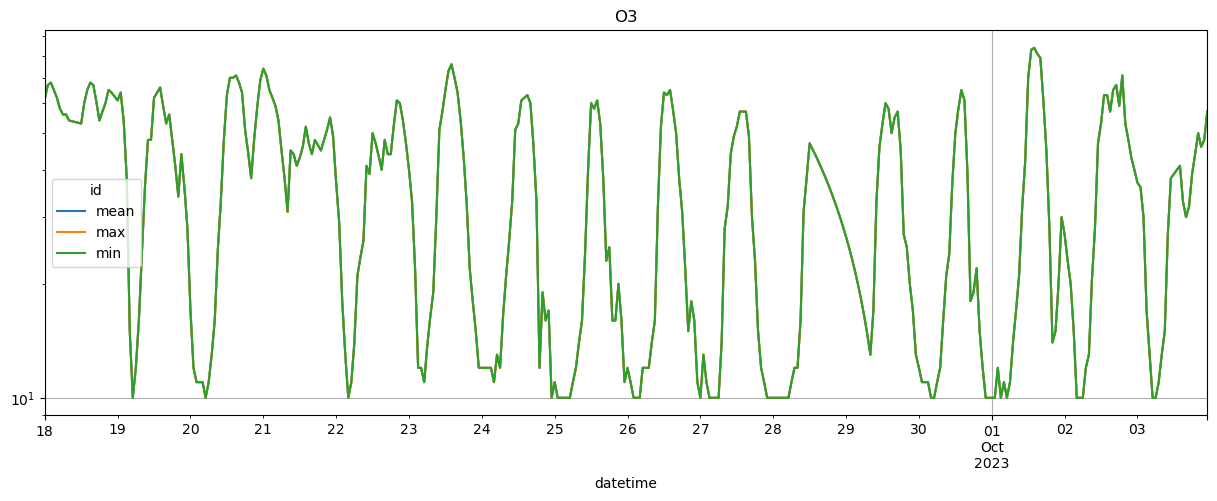

In [19]:
plot_ap(bb_ap_df)

Madrid

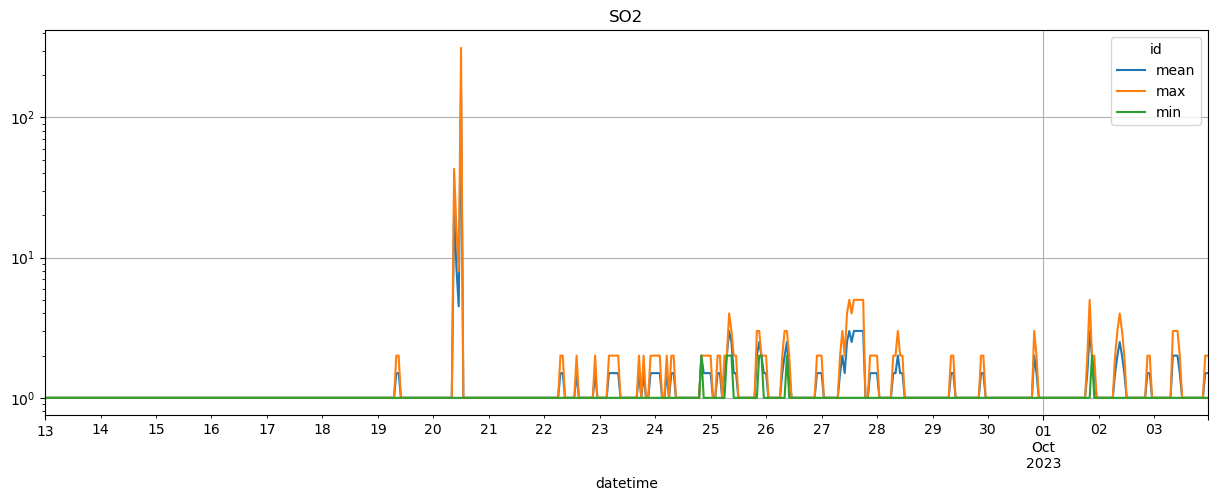

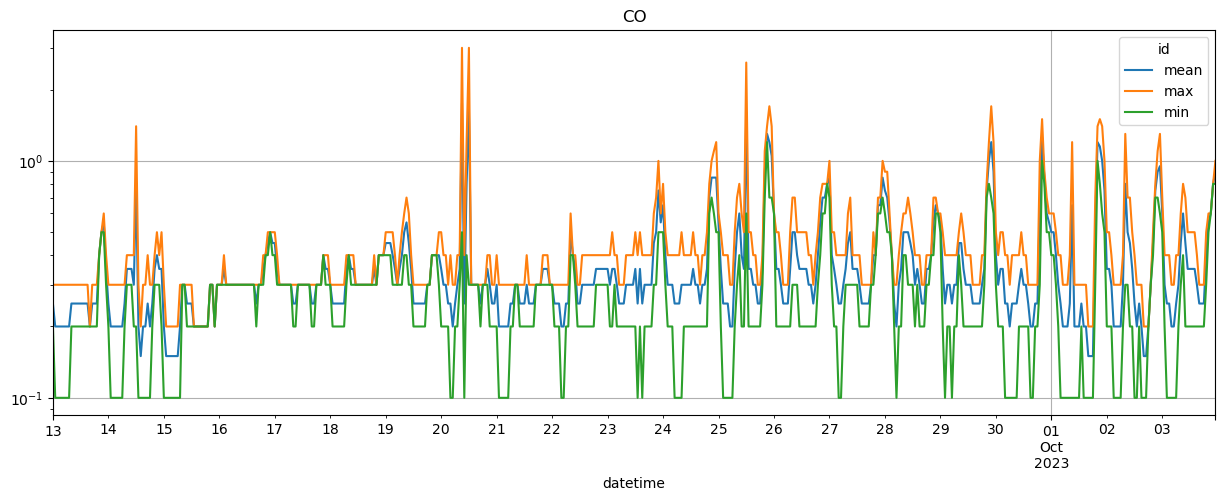

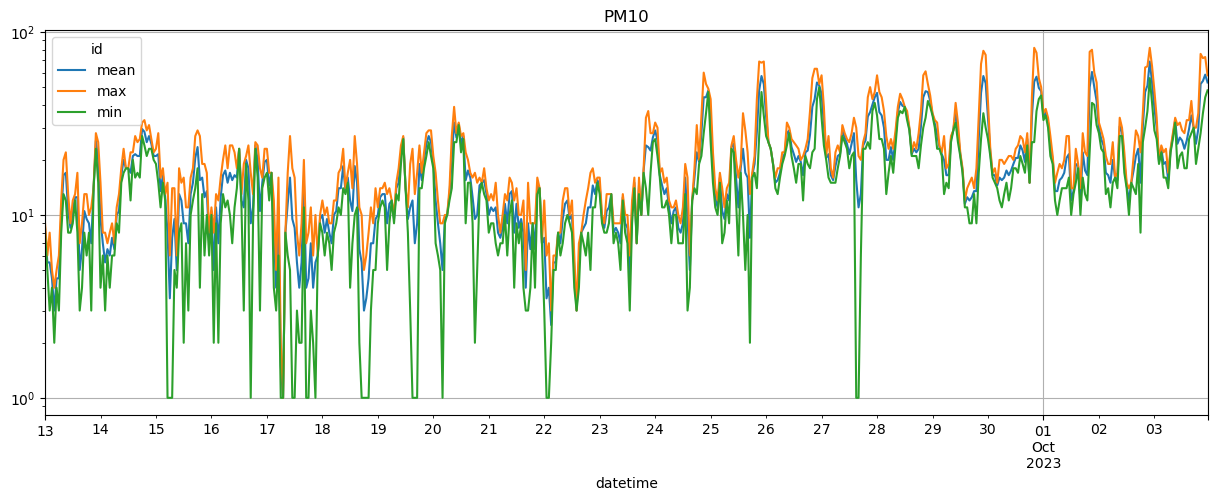

In [20]:
plot_ap(md_ap_df)

### Generate graphs

In [21]:
def generate_graph(ap_id_dict, trf_id_dict, ap_sensors_id, trf_sensors_id, lista_de_fechas_str, trf_df, ap_df):

    dataset={}
    dataset['node_ids']={}
    dataset['node_ids']['trf']=trf_id_dict

    dataset['columns_ids']={}
    dataset['node_ids']['trf']=trf_id_dict

    
    for id_,i in ap_id_dict.items():
        dataset['node_ids'][f'ap{i}']={str(id_):0}
    
    dataset['edges']={}
    dataset['edges_attr']={}

    trf_trf_edges=[]
    trf_trf_edges_attr=[]
    for s1,s2 in itertools.combinations(trf_sensors_id,2):
        i1= trf_id_dict[s1]
        i2= trf_id_dict[s2]

        trf_trf_edges.append([i1,i2])
        trf_trf_edges.append([i2,i1])

        trf_trf_edges_attr.append(matriz_distancias_haversine.at[str(s1),str(s2)])
        trf_trf_edges_attr.append(matriz_distancias_haversine.at[str(s2),str(s1)])
    
    dataset['edges']['trf_close_trf']= trf_trf_edges
    dataset['edges_attr']['trf_close_trf']= trf_trf_edges_attr
   
    for s1,s2 in itertools.combinations(ap_sensors_id,2):
        i1= ap_id_dict[s1]
        i2= ap_id_dict[s2]
        l1= dataset['edges'].get(f'ap{i1}_close_ap{i2}',[])
        l2= dataset['edges'].get(f'ap{i2}_close_ap{i1}',[])
        
        n1=dataset['node_ids'][f'ap{i1}'][str(s1)]
        n2=dataset['node_ids'][f'ap{i2}'][str(s2)]
        
        l1.append([n1,n2])
        l2.append([n2,n1])
        
        dataset['edges'][f'ap{i1}_close_ap{i2}']= l1
        dataset['edges'][f'ap{i2}_close_ap{i1}']= l2
    
        l1_attr= dataset['edges_attr'].get(f'ap{i1}_close_ap{i2}',[])
        l2_attr= dataset['edges_attr'].get(f'ap{i2}_close_ap{i1}',[])
        
        l1_attr.append(matriz_distancias_haversine.at[str(s1),str(s2)])
        l2_attr.append(matriz_distancias_haversine.at[str(s2),str(s1)])
    
        dataset['edges_attr'][f'ap{i1}_close_ap{i2}']= l1_attr
        dataset['edges_attr'][f'ap{i2}_close_ap{i1}']= l2_attr
    
    
    for ap in ap_sensors_id:
        i= ap_id_dict[ap]
        n_ap=dataset['node_ids'][f'ap{i}'][str(ap)]

        dataset['edges'][f'trf_close_ap{i}']=[]
        for trf in trf_sensors_id:
            n_trf= dataset['node_ids']['trf'][trf]
            dataset['edges'][f'trf_close_ap{i}'].append([n_trf,n_ap])
            l_attr= dataset['edges_attr'].get(f'trf_close_ap{i}',[])
            l_attr.append(matriz_distancias_haversine.at[str(trf),str(ap)])
            
            dataset['edges_attr'][f'trf_close_ap{i}']= l_attr
    
    
    dataset['snapshots']={}
    dataset['time_periods']={}
    dataset['snapshots']=[]
    
    i=0
    for d in tqdm(lista_de_fechas):
        d_str= d.strftime("%d/%m/%Y") 
        d_str2= d.strftime("%Y-%m-%d")
        for h in range(0,24):
            h_str= str(h).zfill(2)
            dataset['time_periods'][str(i)]=d_str+'_'+str(h)
        
            snapshot={}
    
            trf_date_df= trf_df[trf_df['DateTime']==f'{d_str2} {h_str}:00:00'].copy()
            trf_date_df['id_num']= trf_date_df['id'].apply(lambda id_: trf_id_dict[id_])
            trf_date_df= trf_date_df.sort_values('id_num')
    
            trf_values= trf_date_df['Car Motorcycle	Bus	Truck'.split()].values
    
            snapshot['trf']=trf_values

            if 'trf' not in dataset['columns_ids']:
                dataset['columns_ids']['trf']= {v:i for (i,v) in list(enumerate('Car Motorcycle Bus Truck'.split()))}

            h_str= str(h).zfill(2)
            ap_date_hour_df= ap_df[ap_df['date']==d][f'id pollutant H{h_str}'.split()]
            ap_date_hour_df= ap_date_hour_df.pivot_table(index='id',columns='pollutant', values=f'H{h_str}')
            #print(ap_date_hour_df)
            #print("*"*8)
            for ap_id, values in ap_date_hour_df.iterrows():
                values_no_nan=values.dropna().values
                columns_no_nan=values.dropna().index.tolist()
                #print(values_no_nan, columns_no_nan)
                ap_num= ap_id_dict[ap_id]
                snapshot[f'ap{ap_num}']= values_no_nan
                if f'ap{ap_num}' not in dataset['columns_ids']:
                    dataset['columns_ids'][f'ap{ap_num}']= {v:i for (i,v) in list(enumerate(columns_no_nan))}
        
            dataset['snapshots'].append(snapshot)
            
            i=i+1
    
    dataset['n_snapshots']=i
    return dataset

#### Madrid

In [22]:
ap_sensors_id= md_ap_df['id'].unique()
trf_sensors_id= md_trf_df['id'].unique()
n_trf_sensors= md_trf_df['id'].nunique()

trf_id_dict= {v:i for (i,v) in list(enumerate(md_trf_df['id'].unique()))}
ap_id_dict= {v:i for (i,v) in list(enumerate(md_ap_df['id'].unique()))}

columns_dict={}

# Definir las fechas de inicio y fin para Madrid
fecha_inicio = datetime(2023, 9, 14, 0, 0)  # Año, mes, día, hora, minuto
fecha_fin = datetime(2023, 10, 3, 0, 0)

# Generar la lista de fechas
lista_de_fechas = generar_lista_de_fechas(fecha_inicio, fecha_fin)
lista_de_fechas_str= [s.strftime("%d/%m/%Y") for s in lista_de_fechas]
lista_de_fechas_yearfirst_str= [s.strftime("%Y/%m/%d") for s in lista_de_fechas]
dataset_md= generate_graph(ap_id_dict, trf_id_dict, ap_sensors_id, trf_sensors_id, lista_de_fechas, md_trf_df, md_ap_df)
pp(dataset_md)

  0%|          | 0/20 [00:00<?, ?it/s]

{'node_ids': {'trf': {'1302': 0,
                      '1303': 1,
                      '1304': 2,
                      '1305': 3,
                      '1316': 4,
                      '1317': 5,
                      '1318': 6,
                      '1323': 7,
                      '1324': 8,
                      '1331': 9,
                      '1332': 10,
                      '4308': 11,
                      '4322': 12},
              'ap0': {'28079004': 0},
              'ap1': {'28079008': 0},
              'ap2': {'28079047': 0},
              'ap3': {'28079049': 0}},
 'columns_ids': {'trf': {'Car': 0, 'Motorcycle': 1, 'Bus': 2, 'Truck': 3},
                 'ap0': {'CO': 0, 'SO2': 1},
                 'ap1': {'CO': 0, 'O3': 1, 'PM10': 2, 'PM25': 3, 'SO2': 4},
                 'ap2': {'PM10': 0, 'PM25': 1},
                 'ap3': {'O3': 0}},
 'edges': {'trf_close_trf': [[0, 1],
                             [1, 0],
                             [0, 2],
                       

#### Bilbao

In [23]:
ap_sensors_id= bb_ap_df['id'].unique()
trf_sensors_id= bb_trf_df['id'].unique()
n_trf_sensors= bb_trf_df['id'].nunique()

trf_id_dict= {v:i for (i,v) in list(enumerate(bb_trf_df['id'].unique()))}
ap_id_dict= {v:i for (i,v) in list(enumerate(bb_ap_df['id'].unique()))}

# Definir las fechas de inicio y fin para Madrid
fecha_inicio = datetime(2023, 9, 13, 0, 0)  # Año, mes, día, hora, minuto
fecha_fin = datetime(2023, 10, 3, 0, 0)

# Generar la lista de fechas
bb_lista_de_fechas = generar_lista_de_fechas(fecha_inicio, fecha_fin)
bb_lista_de_fechas= [s.strftime("%d/%m/%Y") for s in bb_lista_de_fechas]

In [24]:
dataset_bb= generate_graph(ap_id_dict, trf_id_dict, ap_sensors_id, trf_sensors_id, bb_lista_de_fechas, bb_trf_df, bb_ap_df)
pp(dataset_bb)

  0%|          | 0/20 [00:00<?, ?it/s]

{'node_ids': {'trf': {'30': 0,
                      '32': 1,
                      '33': 2,
                      '34': 3,
                      '35': 4,
                      '37': 5,
                      '41': 6,
                      '42': 7,
                      '44': 8,
                      '4': 9,
                      '52': 10,
                      '5': 11,
                      '65': 12,
                      '68': 13,
                      '69': 14,
                      '72': 15,
                      '8': 16},
              'ap0': {'MAZARREDO': 0},
              'ap1': {'M_DIAZ_HARO': 0}},
 'columns_ids': {'trf': {'Car': 0, 'Motorcycle': 1, 'Bus': 2, 'Truck': 3},
                 'ap0': {'CO': 0, 'PM10': 1, 'PM25': 2, 'SO2': 3},
                 'ap1': {'CO': 0, 'O3': 1, 'PM10': 2, 'PM25': 3, 'SO2': 4}},
 'edges': {'trf_close_trf': [[0, 1],
                             [1, 0],
                             [0, 2],
                             [2, 0],
                    

In [25]:
if not os.path.exists(os.path.join(data_path, 'graph_structure')):
    os.makedirs(os.path.join(data_path, 'graph_structure'))

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

with open(os.path.join(data_path, 'graph_structure','md_graph.json'), 'w') as outfile:
    json.dump(dataset_md, outfile, cls=NpEncoder)

with open(os.path.join(data_path, 'graph_structure','bb_graph.json'), 'w') as outfile:
    json.dump(dataset_bb, outfile, cls=NpEncoder)

### Test dataset loader

In [26]:
import json
import os
import urllib
import numpy as np
from torch_geometric_temporal.signal import StaticHeteroGraphTemporalSignal

class AirpollutionDatasetLoader(object):

    def __init__(self, city, include_trf=True):
        self.city= city
        self._include_trf= include_trf
        self._read_file_data()
        

    def _read_file_data(self):
        
        if self.city=='bilbao':
            with open(os.path.join('data', 'graph_structure', 'bb_graph.json')) as f:
                self._dataset = json.load(f)
        elif self.city=='madrid':
            with open(os.path.join('data', 'graph_structure', 'md_graph.json')) as f:
                self._dataset = json.load(f)
        else:
            raise ValueError()
        self.n_total_snapshots= self._dataset['n_snapshots']
        
    def _get_edges(self):
        self._edges={}
        for s, values in self._dataset["edges"].items():
            edge_name= tuple(s.split('_'))
            if self._include_trf or ('trf' not in edge_name):
                self._edges[edge_name]= np.array(values).T

    def _get_edge_weights(self):
        self._edge_weights={}
        for s, values in self._dataset["edges_attr"].items():
            edge_name= tuple(s.split('_'))
            if self._include_trf or ('trf' not in edge_name):
                self._edge_weights[edge_name]= np.array(values)

    def _get_targets_and_features(self):
        self.features=[]
        self.targets=[]
        self._feature_dim={}
                
        for snapshot_index in range(0,self.n_total_snapshots-self._T):
            feat_snapshot= self._dataset['snapshots'][snapshot_index]
            feat_snapshot_dict={}
            for node, values in feat_snapshot.items():
                if self._include_trf or ('trf' != node):
                    values = np.array(values)
                                
                    if node != 'trf':
                        values= values.reshape(-1,len(values))
                    
                    feat_snapshot_dict[node]=values
                    if node not in self._feature_dim:
                        self._feature_dim[node]=values.shape[1]
                
            self.features.append(feat_snapshot_dict)
            
            target_snapshot= self._dataset['snapshots'][snapshot_index+self._T]
            target_snapshot_dict={}
            for node, values in target_snapshot.items():
                if self._include_trf or ('trf' != node):
                    values = np.array(values)
                                
                    if node != 'trf':
                        values= values.reshape(-1,len(values))
         
                    target_snapshot_dict[node]=values
            self.targets.append(target_snapshot_dict)

    def _get_columns_names(self):
        self._column_names= {}
        for k,v in self._dataset['columns_ids'].items():
            if self._include_trf or ('trf' != k):
                sorted_v = sorted(v.items(), key=lambda x: x[1])
                ordered_columns = [item[0] for item in sorted_v]
                self._column_names[k]= ordered_columns
        
    def get_dataset(self, T= 1) -> StaticHeteroGraphTemporalSignal:
        """Returning the Spanish Airpollution data iterator.

        Args types:
            * **T** *(int)* - The time horizon.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Spanish Air Pollution dataset.
        """
        self._T = T
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        self._get_columns_names()
        dataset = StaticHeteroGraphTemporalSignal(self._edges, self._edge_weights, self.features, self.targets)
        return dataset
    
    def get_feature_dim(self):
        return self._feature_dim
    
    def get_n_total_snapshots(self):
        return self.n_total_snapshots

    def get_column_names(self, node_type):
        return self._column_names[node_type]

In [57]:
loader= AirpollutionDatasetLoader('madrid', include_trf=True)
dataset=loader.get_dataset(T=6) # T is the time horizon in hours

In [58]:
loader.get_feature_dim()

{'trf': 4, 'ap0': 2, 'ap1': 5, 'ap2': 2, 'ap3': 1}

In [59]:
loader.get_n_total_snapshots()

480

In [60]:
loader.get_column_names('ap2'), loader.get_column_names('ap0'), loader.get_column_names('ap1')

(['PM10', 'PM25'], ['CO', 'SO2'], ['CO', 'O3', 'PM10', 'PM25', 'SO2'])

In [61]:
for snapshot in dataset:
    print(snapshot)  

HeteroData(
  trf={
    x=[13, 4],
    y=[13, 4]
  },
  ap0={
    x=[1, 2],
    y=[1, 2]
  },
  ap1={
    x=[1, 5],
    y=[1, 5]
  },
  ap2={
    x=[1, 2],
    y=[1, 2]
  },
  ap3={
    x=[1, 1],
    y=[1, 1]
  },
  (trf, close, trf)={
    edge_index=[2, 156],
    edge_attr=[156]
  },
  (ap0, close, ap1)={
    edge_index=[2, 1],
    edge_attr=[1]
  },
  (ap1, close, ap0)={
    edge_index=[2, 1],
    edge_attr=[1]
  },
  (ap0, close, ap2)={
    edge_index=[2, 1],
    edge_attr=[1]
  },
  (ap2, close, ap0)={
    edge_index=[2, 1],
    edge_attr=[1]
  },
  (ap0, close, ap3)={
    edge_index=[2, 1],
    edge_attr=[1]
  },
  (ap3, close, ap0)={
    edge_index=[2, 1],
    edge_attr=[1]
  },
  (ap1, close, ap2)={
    edge_index=[2, 1],
    edge_attr=[1]
  },
  (ap2, close, ap1)={
    edge_index=[2, 1],
    edge_attr=[1]
  },
  (ap1, close, ap3)={
    edge_index=[2, 1],
    edge_attr=[1]
  },
  (ap3, close, ap1)={
    edge_index=[2, 1],
    edge_attr=[1]
  },
  (ap2, close, ap3)={
    edge_ind

Check that the values in the dataset loader

Traffic

In [56]:
snapshot_test = dataset[23]
snapshot_test['trf'].x

AttributeError: 'NodeStorage' object has no attribute 'x'

In [33]:
dataset_md['snapshots'][24]['trf']

array([[142,   0,  27,   3],
       [ 21,   0,   0,   0],
       [120,   0,   1,   6],
       [102,   0,   7,   5],
       [ 48,  14,   0,   0],
       [ 68,   1,   2,   2],
       [ 39,  21,   0,   0],
       [ 25,   0,   1,   1],
       [130,   2,   5,   3],
       [  8,   0,   0,   0],
       [  8,   0,   0,   0],
       [ 13,   2,   1,   1],
       [ 46,   0,   2,   1]], dtype=int64)

In [34]:
dataset_md['time_periods']['23']

'14/09/2023_23'

In [35]:
md_trf_df[md_trf_df['DateTime']=='2023-09-14 23:00:00']

DateTime  Car  Motorcycle  Bus  Truck    id
37 2023-09-14 23:00:00   93           0    7      1  1302
37 2023-09-14 23:00:00   14           0    0      0  1303
37 2023-09-14 23:00:00   92           1    7      4  1304
37 2023-09-14 23:00:00  107           0    7      6  1305
37 2023-09-14 23:00:00   33          10    4      0  1316
37 2023-09-14 23:00:00   74           3    4      2  1317
37 2023-09-14 23:00:00   35          22    3      0  1318
37 2023-09-14 23:00:00   22           0    1      0  1323
37 2023-09-14 23:00:00  105           6    9      4  1324
37 2023-09-14 23:00:00   10           0    0      0  1331
37 2023-09-14 23:00:00    5           0    0      0  1332
37 2023-09-14 23:00:00    8           0    1      5  4308
37 2023-09-14 23:00:00   25           1    4      1  4322

In [36]:
snapshot_test = dataset[23]
snapshot_test['trf'].y

tensor([[30,  0, 20,  4],
        [ 5,  0,  0,  0],
        [30,  0,  2,  3],
        [24,  0,  3,  6],
        [18,  1,  0,  0],
        [33,  0,  0,  2],
        [26,  4,  0,  0],
        [ 2,  0,  1,  0],
        [31,  0,  5,  2],
        [ 4,  0,  0,  0],
        [ 3,  0,  0,  1],
        [ 9,  0,  0,  1],
        [ 6,  0,  0,  1]])

In [37]:
dataset_md['snapshots'][29]['trf']

array([[30,  0, 20,  4],
       [ 5,  0,  0,  0],
       [30,  0,  2,  3],
       [24,  0,  3,  6],
       [18,  1,  0,  0],
       [33,  0,  0,  2],
       [26,  4,  0,  0],
       [ 2,  0,  1,  0],
       [31,  0,  5,  2],
       [ 4,  0,  0,  0],
       [ 3,  0,  0,  1],
       [ 9,  0,  0,  1],
       [ 6,  0,  0,  1]], dtype=int64)

In [38]:
dataset_md['time_periods']['29']

'15/09/2023_5'

In [39]:
md_trf_df[md_trf_df['DateTime']=='2023-09-15 05:00:00']

DateTime  Car  Motorcycle  Bus  Truck    id
43 2023-09-15 05:00:00   30           0   20      4  1302
43 2023-09-15 05:00:00    5           0    0      0  1303
43 2023-09-15 05:00:00   30           0    2      3  1304
43 2023-09-15 05:00:00   24           0    3      6  1305
43 2023-09-15 05:00:00   18           1    0      0  1316
43 2023-09-15 05:00:00   33           0    0      2  1317
43 2023-09-15 05:00:00   26           4    0      0  1318
43 2023-09-15 05:00:00    2           0    1      0  1323
43 2023-09-15 05:00:00   31           0    5      2  1324
43 2023-09-15 05:00:00    4           0    0      0  1331
43 2023-09-15 05:00:00    3           0    0      1  1332
43 2023-09-15 05:00:00    9           0    0      1  4308
43 2023-09-15 05:00:00    6           0    0      1  4322

Air pollution

In [40]:
snapshot_test['ap1'].x

tensor([[ 0.2000, 39.0000, 22.0000,  2.0000,  1.0000]])

In [41]:
md_pollutants_per_sensor_df

id           pollutants
0  28079004               SO2 CO
1  28079008  SO2 CO PM25 PM10 O3
2  28079047            PM25 PM10
3  28079049                   O3

In [42]:
dataset_md['snapshots'][23]['ap1']

array([ 0.2, 39. , 22. ,  2. ,  1. ])

In [43]:
dataset_md['time_periods']['23']

'14/09/2023_23'

In [44]:
dataset_md['node_ids']['ap1']

{'28079008': 0}

In [45]:
md_ap_df[(md_ap_df['id']==28079008) & (md_ap_df['date']=='2023-09-14')]

H00   H01   H02   H03   H04   H05   H06   H07   H08   H09  ...   H17  \
37    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   1.0   
55    0.2   0.1   0.1   0.1   0.1   0.1   0.1   0.2   0.3   0.3  ...   0.1   
73    1.0   2.0   1.0   2.0   1.0   1.0   2.0   3.0   1.0   3.0  ...   2.0   
91    4.0   6.0   3.0   6.0   4.0   6.0   6.0   9.0   8.0  15.0  ...  16.0   
109  45.0  50.0  51.0  45.0  46.0  45.0  42.0  28.0  15.0  17.0  ...  63.0   

      H18   H19   H20   H21   H22   H23        id       date  pollutant  
37    1.0   1.0   1.0   1.0   1.0   1.0  28079008 2023-09-14        SO2  
55    0.1   0.2   0.3   0.3   0.3   0.2  28079008 2023-09-14         CO  
73   11.0  18.0   2.0   2.0   3.0   2.0  28079008 2023-09-14       PM25  
91   27.0  33.0  21.0  23.0  23.0  22.0  28079008 2023-09-14       PM10  
109  61.0  58.0  41.0  32.0  29.0  39.0  28079008 2023-09-14         O3  

[5 rows x 27 columns]

In [46]:
snapshot_test['ap1'].y

tensor([[ 0.1000, 55.0000,  1.0000,  1.0000,  1.0000]])

In [47]:
dataset_md['snapshots'][7]['ap1']

array([ 0.2, 28. ,  9. ,  3. ,  1. ])

In [48]:
dataset_md['time_periods']['7']

'14/09/2023_7'

In [49]:
print("That's all folks!")

That's all folks!
